In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt


#np.set_printoptions(precision=4)
import math
from utils import *

nS = 8
nA = 2
seed = get_current_seed()
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, gamma=gamma, small=5, large=1000, seed=seed)
tau = 0.5
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)


Current seed for result reproducibility: 132197388802493357552003233356640263467


In [2]:
Q_star, _ = bellman_optimal_q(tmdp.P_mat_tau, tmdp.reward, gamma).values()
pi = get_policy(Q_star)
print(Q_star)

[[192.32880525 189.13661796]
 [189.51630549 188.20638369]
 [188.25068062 187.66121581]
 [187.68114945 187.6218458 ]
 [187.42486044 188.95045693]
 [187.99604883 196.44325045]
 [191.36780594 236.53673494]
 [209.40987398 450.84094187]]


In [3]:
status_step = 500000
episodes = 10000000
batch_size = 1
temperature = 20

In [4]:
"""tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
Q = np.zeros((nS, nA))
Qs = Q_learning(tmdp, Q, alpha=.25, episodes=episodes, status_step=status_step)"""

'tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)\nQ = np.zeros((nS, nA))\nQs = Q_learning(tmdp, Q, alpha=.25, episodes=episodes, status_step=status_step)'

In [5]:
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
Q = np.zeros((nS, nA))
batch_Qs = batch_q_learning(tmdp, Q, alpha=.25, episodes=episodes, status_step=status_step, batch_size=batch_size)

In [ ]:
Q_p=np.zeros((nS, nA))
Q_xi = np.zeros((nS, nA))
pg_res = policy_gradient(tmdp, Q_p, Q_xi, alpha=0.25, episodes=episodes, status_step=status_step, batch_size=batch_size, temperature=temperature)


In [ ]:
Q_p=np.zeros((nS, nA))
Q_xi = np.zeros((nS, nA))
double_q = batch_double_q_learning(tmdp, Q_p, Q_xi, alpha=0.25, episodes=episodes, status_step=status_step, batch_size=batch_size)


In [ ]:
#print(batch_Qs["Qs"][-1])
#print(pg_res["Qs"][-1])
print(double_q["Qs"][-1])
print(double_q["Q_ps"][-1])
print(double_q["Q_xis"][-1])
#print(Q_star)

[[ 62.9161704   72.19470558]
 [ 64.57060644  92.59636838]
 [ 79.4250325  129.06656598]
 [112.89090415 190.65807439]
 [184.63232036 292.40150565]
 [276.78687212 425.11914171]
 [419.49700798 647.44796821]
 [550.87704302 956.00700427]]
[[ 62.98268114  72.25121355]
 [ 64.57060644  92.64223532]
 [ 79.4250325  129.11636303]
 [112.89090415 190.72355487]
 [184.63232036 292.48372321]
 [276.78687212 425.22237979]
 [419.49700798 647.56639772]
 [550.87704302 954.53642001]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [ ]:
tau_prime = 0.
pg_metrics = compute_metrics(tmdp, pg_res["Qs"], Q_star, pg_res["disc_visits_distributions"], tau_prime=tau_prime)#, is_policy=True, temperature=temperature)
batch_metrics = compute_metrics(tmdp, batch_Qs["Qs"], Q_star, batch_Qs["disc_visits_distributions"], tau_prime=tau_prime)
double_q_metrics = compute_metrics(tmdp, double_q["Qs"], Q_star, double_q["disc_visits_distributions"], tau_prime=tau_prime)
double_q_metrics_p = compute_metrics(tmdp, double_q["Q_ps"], Q_star, double_q["disc_visits_distributions"], tau_prime=tau_prime)

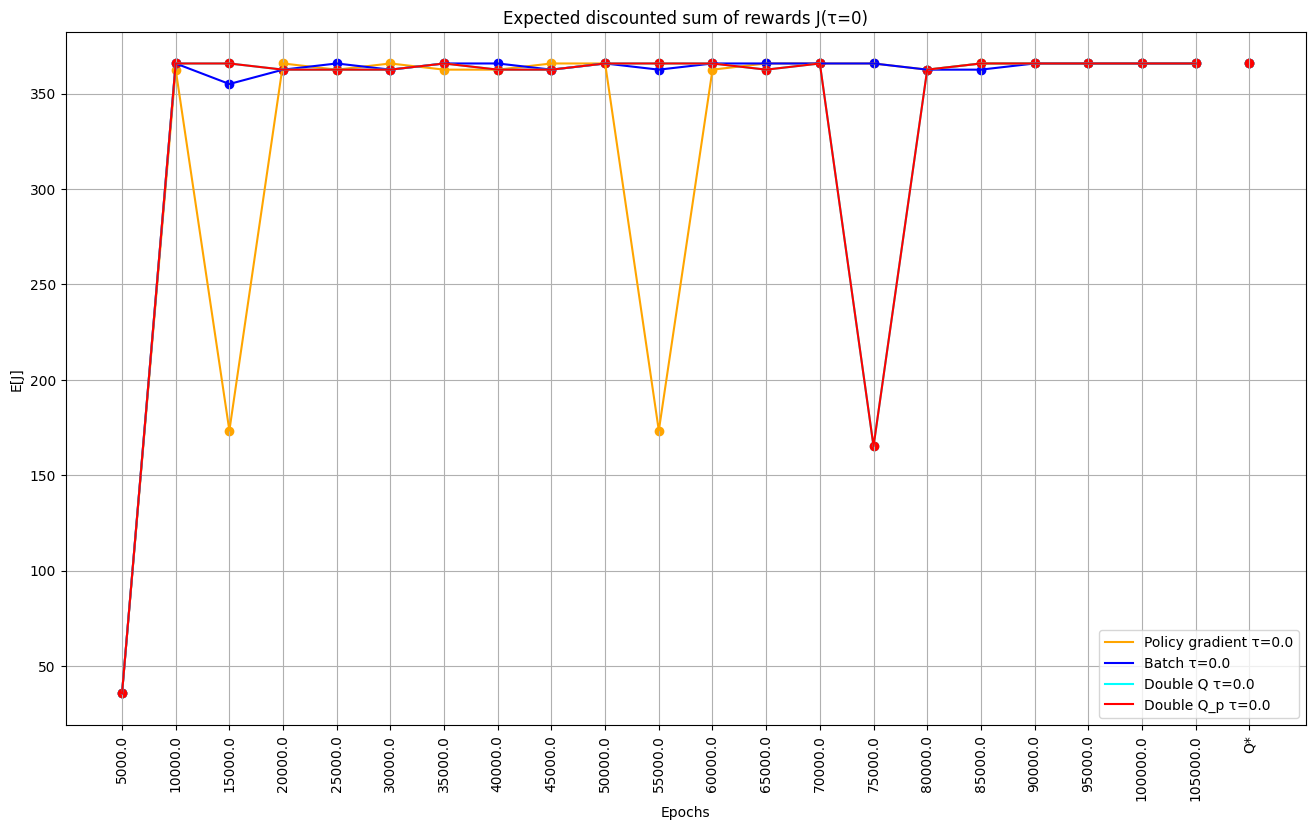

In [ ]:
x = np.array([])
y_0 = np.array([])
y = np.array([])
y_d = np.array([])
y_p = np.array([])

for i, J in enumerate(pg_metrics["J"]):
    y = np.append(y, J)
    y_0 = np.append(y_0, batch_metrics["J"][i])
    y_d = np.append(y_d, double_q_metrics["J"][i])
    y_p = np.append(y_p, double_q_metrics_p["J"][i])
    if i < len(batch_metrics["J"])-1:
        x = np.append(x, (i+1)*status_step)
    else:
        x = np.append(x, "Q*")
x_map = np.array([i for i in range(len(x))])
plt.figure(figsize=(16,9))
plt.xticks(rotation=90, fontsize=10)
plt.scatter(x, y, c="orange")
plt.scatter(x, y_0, c="blue")
plt.scatter(x, y_d, c="cyan")
plt.scatter(x, y_p, c="red")

plt.plot(x[:-1], y[:-1], c="orange", label="Policy gradient τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_0[:-1], c="blue", label="Batch τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_d[:-1], c="cyan", label="Double Q τ={}".format(tmdp.tau))
plt.plot(x[:-1], y_p[:-1], c="red", label="Double Q_p τ={}".format(tmdp.tau))
plt.legend(loc="lower right")
plt.xlabel("Epochs")
plt.ylabel("E[J]")
plt.title("Expected discounted sum of rewards J(τ=0)")
plt.grid(visible=True)


In [ ]:
print(batch_Qs["disc_visits_distributions"][-1])
print(batch_Qs["visits_distributions"][-2])

d = compute_d_from_tau(tmdp.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(Q_star, False), tmdp.gamma, tmdp.tau)
print(d)

[0.05223542 0.07585674 0.09211708 0.10436151 0.11816314 0.15197153
 0.28336504 0.12192954]
[0.0408131  0.06884645 0.09946944 0.1266501  0.15663095 0.19299114
 0.24257322 0.0720256 ]
[0.32372294 0.15619252 0.12146807 0.10816693 0.0985787  0.08789695
 0.0740248  0.02994908]
